In [1]:
%load_ext autoreload
%autoreload 2
%autosave 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from tqdm.notebook import tqdm
import numpy as np
from fastai.text import *
from modules.callbacks import *
from pathlib2 import Path
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
from modules.model import *

defaults.device = torch.device('cuda')
#CUDA_VISIBLE_DEVICES=""
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 2 seconds


cuda


In [2]:
## Writing processed data into pickle file

#pickle.dump(qs, open('fr-2-en-data/fr-en-qs.pkl','wb'))
qs = pickle.load(open('fr-2-en-data/fr-en-qs.pkl','rb'))

en_qs,fr_qs = zip(*qs)

In [3]:
path = Path()

In [4]:
en_tok = pickle.load((path/'fr-2-en-data/en_tok.pkl').open('rb'))
fr_tok = pickle.load((path/'fr-2-en-data/fr_tok.pkl').open('rb'))

In [5]:
TMP_PATH = path/'fr-2-en-data/tmp/'

def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy',allow_pickle=True)
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [6]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

## Fastai's Data Bunch

In [7]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    
    # unpack samples to tuples
    samples = to_data(samples)
    
    # find max len of x, y batch wihich decides inp seq length
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    
    max_len = max(max_len_x,max_len_y)
    
    # create a dummy tensor of height batch_size and width max_len with padded value
    res_x = torch.zeros(len(samples), max_len).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len).long() + pad_idx
    
    # if backwards activate reverse mode used in bi-directional   
    if backwards: pad_first = not pad_first
    
    # fill vocabulary indices
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    
    # flip backward if backwards = True
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
        
    res_x_mask = (res_x != pad_idx).unsqueeze(-2)
    res_y_mask = None
    
    # target mask creation
    if res_y is not None:
        dec_y = res_y[:, :-1]
        tar_y = res_y[:, 1:]
        decode_lengths = torch.tensor([len(s[1]) for s in samples])-1
    return (res_x[:,1:],dec_y,decode_lengths), tar_y

In [8]:
class Seq2SeqDataBunch(TextDataBunch):
    " decorator adds following method additionally to base class 'TextDataBunch"
    
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=8, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=device, no_check=True, backwards:bool=False, **dl_kwargs)-> DataBunch:
        
        "Function takes pytorch dataset object transforms into 'databunch' for classification and cls will allow to access parent class methods just  like 'self'"
        
        # store dataset obj into list
        datasets = cls._init_ds(train_ds,valid_ds,test_ds)
        val_bs = ifnone(val_bs, bs) #returns val_bs if none bs
        
        # stores raw seq of unequal len into tensor with padding
        # below function takes batches output from Dataloader returns padded tensor
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        #sampler function: generater takes dataset then sorts and returns sorted indices    
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        
        # train data loader obj with Sortish sampler(sort with some randomness)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        
        # other dataloaders with pure sorting append into dataloaders list
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key = lengths.__getitem__)
            dataloaders.append(DataLoader(ds,batch_size=val_bs,
                                          sampler = sampler,**dl_kwargs))
        
        return cls(*dataloaders, path = path, device = device, collate_fn=collate_fn, no_check = no_check)

In [9]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.width', 10000)
pd.set_option('display.expand_frame_repr', True)


data = pd.DataFrame(qs, columns=['en', 'fr'])

In [48]:
data.sample(5)[['fr', 'en']].style.set_properties(subset=['fr', 'en'], **{'width': '300px'})

,fr,en
7957,En quoi consiste une inspection d'un agent des pêches?,What happens if I'm inspected by a fishery officer?
23052,Quels sont les avantages et les inconvénients du système de La Haye pour un utilisateur tel que vous?,What are the pluses/minuses of the Hague system for you as an individual user?
34628,À qui ces activités douteuses profitent-elles?,Who profits from this dubious activity?
29141,Quelles sont les forces et faiblesses du programme de la PNE et des activités qui y sont associées?,What are the strengths and weaknesses of the NCB Program and its activities?
22353,• Que fait l'OMPI en plus de traiter les affaires soumises en application des principes UDRP?,What is WIPO doing in addition to administering cases under the UDRP?


In [29]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [11]:
# lowercase
data['en'] = data['en'].apply(lambda x:x.lower())
data['fr'] = data['fr'].apply(lambda x:x.lower())

### create a Seq2SeqTextList (Fastai's datablock api)

In [12]:
# text list with 'fr' column as label  and split list randomly (0.8) 
src = (Seq2SeqTextList.from_df(data, path = path, cols='fr')
       .split_by_rand_pct(seed=42)
       .label_from_df(cols='en',label_cls=TextList))

In [13]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [14]:
from modules.model import *
from modules.callbacks import *
from transformer.model import Translation

en_emb = torch.load('models/en_emb.pth')
fr_emb = torch.load('models/fr_emb.pth')

databunch = src.databunch()
databunch.batch_size = 64

'''
(Pdb) dec_input
['[SOS]', 'Bible', 'Color', '##ing', "'", 'is', 'a', 'coloring', 'application', 'that', 'allows', 'you', 'to', 
'experience', 'beautiful', 'stories', 'in', 'the', 'Bible', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 
'[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 
'[PAD]', '[PAD]', '[PAD]', '[PAD]']

(Pdb) dec_output
['Bible', 'Color', '##ing', "'", 'is', 'a', 'coloring', 'application', 'that', 'allows', 'you', 'to', 
'experience', 'beautiful', 'stories', 'in', 'the', 'Bible', '.', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 
'[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 
'[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

-> dec_inputs.append(dec_input)

(Pdb) dec_input
[1, 5907, 13068, 1160, 114, 1112, 172, 25889, 4050, 1117, 3645, 1130, 1108, 2543, 2714, 2803, 1109, 1105, 
5907, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

(Pdb) dec_output
[5907, 13068, 1160, 114, 1112, 172, 25889, 4050, 1117, 3645, 1130, 1108, 2543, 2714, 2803, 1109, 1105, 
5907, 121, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
'''



'''{'kor_vocab_length': 50000,
 'eng_vocab_length': 28998,
 'd_model': 768,
 'd_ff': 2048,
 'd_k': 64,
 'd_v': 64,
 'num_layers': 12,
 'num_heads': 8,
 'start_word': '[SOS]', #xxbos
 'end_word': '[EOS]',
 'sep_word': '[SEP]',
 'cls_word': '[CLS]',
 'pad_word': '[PAD]', #xxpad
 'mask_word': '[MASK]'} #xxpad 0'''

'''model = Translation(src_vocab_size=len(fr_stoi),
    tgt_vocab_size=len(en_stoi),
    d_model=300, d_ff=2048,
    d_k=64, d_v=64, n_heads=6, 
    n_layers=6, src_pad_index=src_pad_index,
    tgt_pad_index=src_pad_index, device=device)'''

#model = make_model(len(fr_stoi), len(en_stoi), N=6, h = 6, d_model=300,src_embedding = None,tar_embedding = None).to(device);
model = Translation(src_vocab_size=len(fr_stoi),
    tgt_vocab_size=len(en_stoi),
    d_model=300, d_ff=2048,
    d_k=64, d_v=64, n_heads=6, 
    n_layers=6, src_pad_index=1,
    tgt_pad_index=1, device=device)


In [20]:
dict(src_vocab_size=len(fr_stoi),
    tgt_vocab_size=len(en_stoi),
    d_model=300, d_ff=2048,
    d_k=64, d_v=64, n_heads=6, 
    n_layers=6, src_pad_index=1,
    tgt_pad_index=1, device=device)

{'src_vocab_size': 22188,
 'tgt_vocab_size': 14236,
 'd_model': 300,
 'd_ff': 2048,
 'd_k': 64,
 'd_v': 64,
 'n_heads': 6,
 'n_layers': 6,
 'src_pad_index': 1,
 'tgt_pad_index': 1,
 'device': device(type='cuda')}

### Fastai - with CrossEntropyLoss

In [15]:
def CrossEntropy_loss(input,targets):
    pred,_,_,_,decode_lengths = input
    x,y = pred.contiguous().view(-1, pred.size(-1)), targets.contiguous().view(-1)
    loss = nn.CrossEntropyLoss().to(device)(F.log_softmax(x, dim=-1), y)
    return  loss #loss(pred.data.long(), targets.data.long())


In [22]:
opt_fn = partial(optim.Adam, betas=(0.9, 0.98))

criterion = LabelSmoothing(len(en_itos), 1, 0.1).to(device)

learn_CEL = Learner(databunch,model,loss_func=CrossEntropy_loss,wd=0.01, metrics=[seq2seq_acc, CorpusBLEU(len(en_itos))],callback_fns=[ShowGraph]) #,TeacherForcingTurnOff,TeacherForcingCallbacklearn = 

/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


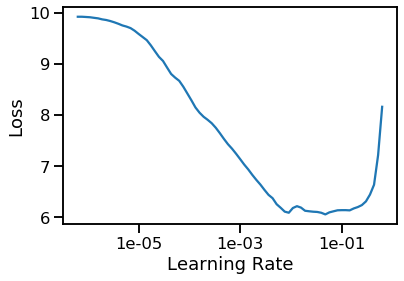

In [23]:
learn_CEL.lr_find()
learn_CEL.recorder.plot()

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.493803,2.653781,0.612998,0.435762,01:27
1,2.039438,2.202004,0.655146,0.464735,01:27
2,1.653983,1.914347,0.682386,0.491546,01:27
3,1.395650,1.718305,0.704167,0.513831,01:30
4,1.066414,1.588531,0.721073,0.533356,01:30
5,0.720392,1.550273,0.735501,0.556514,01:27
6,0.412083,1.577620,0.742560,0.572512,01:28
7,0.187984,1.641869,0.747097,0.584229,01:28
8,0.075525,1.680431,0.748727,0.587891,01:31
9,0.042838,1.701194,0.749782,0.589295,01:31


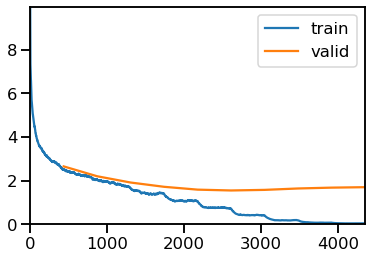

In [24]:
learn_CEL.fit_one_cycle(10, 5e-4, div_factor=5)

In [19]:
#learner = load_learner('.')

In [29]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)[0]
            for x,y,z in zip(xb[0],yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [2]:
inputs, targets, outputs = get_predictions(learn_CEL)

NameError: name 'get_predictions' is not defined

In [1]:
inputs[10],targets[10],outputs[10]


NameError: name 'inputs' is not defined

### Fastai - with LabelSmoothingLoss

In [27]:
def cus_LabelSmoothingCrossEntropy(input,targets):
    pred,_,_,_,decode_lengths = input
    x,y = pred.contiguous().view(-1, pred.size(-1)), targets.contiguous().view(-1)
    loss = LabelSmoothingCrossEntropy().to(device)(x,y)
    return loss

In [28]:
opt_fn = partial(optim.Adam, betas=(0.9, 0.98))

criterion = LabelSmoothing(len(en_itos), 1, 0.1).to(device)

learn_LSL = Learner(databunch,model,loss_func=cus_LabelSmoothingCrossEntropy,wd=0.01, metrics=[seq2seq_acc, CorpusBLEU(len(en_itos))],callback_fns=[ShowGraph]) #,TeacherForcingTurnOff,TeacherForcingCallbacklearn = 

/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 4.79E-03


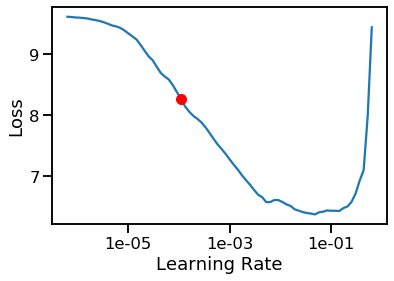

In [24]:
learn_LSL.lr_find()
learn_LSL.recorder.plot(suggestion=True)

In [29]:
learn_LSL.fit_one_cycle(10, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


RuntimeError: CUDA out of memory. Tried to allocate 102.00 MiB (GPU 0; 5.77 GiB total capacity; 4.05 GiB already allocated; 101.75 MiB free; 4.48 GiB reserved in total by PyTorch)

In [19]:
#learner = load_learner('.')

In [49]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)[0]
            set_trace()
            for x,y,z in zip(xb[0],yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [50]:
inputs, targets, outputs = get_predictions(learn)

> <ipython-input-49-cfb436c6d825>(8)get_predictions()
-> for x,y,z in zip(xb[0],yb,out):
(Pdb) n
> <ipython-input-49-cfb436c6d825>(9)get_predictions()
-> inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
(Pdb) x.shape
torch.Size([29])
(Pdb) out.shape
torch.Size([10, 29, 14236])
(Pdb) y.shape
torch.Size([29])
(Pdb) z.shape
torch.Size([29, 14236])
(Pdb) z.cpu().argmax(1)
tensor([ 11,  14,  10, 154,  12,  10,   9,  10,   0, 126,  27,   0,   9,   9,
         10,   9,  10,   9,  10,   0,   9,   9,  10,   9,   9,   9,   1,   1,
          1])
(Pdb) xb[0][0,:]
tensor([  27,   19,   12,  427,   23, 4683,   37,   47,   37,  590,   10, 3606,
          10,   59,  102,  296, 1795,   10,  712,   17,   13,  370, 7141,   16,
          81,   10,   59, 2152,    9], device='cuda:0')
(Pdb) learn.predict(z.cpu().argmax(1))
*** ValueError: only one element tensors can be converted to Python scalars
(Pdb) learn.predict('uelles sont les priorités relatives des différents projets , existe - il une rela

BdbQuit: 

### Model Deplotment

In [90]:
learn.model.eval()
text = "qu'est-ce que la lumière?"
enc_inp = torch.tensor(databunch.x.process_one(text)).unsqueeze(0)
dec_out = [2]
dec_len = torch.tensor([50])

while len(dec_out) < 50:
    dec_input = torch.as_tensor([dec_out], dtype=torch.long)
    enc_inp,dec_input,dec_len=[i.to('cuda') for i in (enc_inp,dec_input,dec_len)]
    with torch.no_grad():
        out = learn.model(enc_inp[:,1:],dec_input,dec_len)
    predict = out[0].squeeze(0).argmax(1)[-1].detach().cpu().numpy()
    dec_out.append(int(predict))

In [96]:
learn.data.train_ds.y.reconstruct(torch.as_tensor([dec_out], dtype=torch.long)[0])

Text xxbos what is the role of the xxunk ?

In [95]:
torch.as_tensor([dec_out], dtype=torch.long)

tensor([[ 2, 11, 14, 10, 79, 12, 10,  0,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [77]:
out[0].squeeze(0).argmax(1)
out_text = learn.data.train_ds.y.reconstruct(out[0].squeeze(0).argmax(1))

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [26]:
inputs[21], targets[21], outputs[21]

(Text quelles sont les priorités relatives des différents projets , existe - il une relation xxunk , et ces priorités doivent - elles toutes être incluses dans le xxunk ?,
 Text what are the relative priorities of the various projects , is there a xxunk relationship , and should they all be included in the xxunk ?,
 Text what are the priorities priorities for different different priority , and , a canadian priorities with and should this be of excluded in all xxunk ?)

### Traditional 

#### Dataloaders

In [16]:
train_dl = databunch.train_dl
valid_dl = databunch.valid_dl

In [17]:
# run one epoch funtion


def run_epoch(dataloader, model, loss_fn, metrics = None):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, (x,y) in enumerate(dataloader):
        out = model.forward(*x)
        loss = loss_fn(out,y)
        total_loss += loss
        total_tokens += out[1].sum().item()
        tokens += out[1].sum().item()
        
        if i%50 == 1:
            elapsed = time.time() - start
            print(f"Epoch Step: {i} Loss: {loss / out[1].sum().item()} Tokens per Sec: {tokens / elapsed}")
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [18]:
# Stepper optim funtion

class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "updates weights and bias based on the loss"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
    
    def rate(self, step = None):
        " Implement 'lrate' above"
        if step is None:
            step = self._step
            
        return self.factor * (self.model_size ** (-.5) * \
                             min(step ** (-0.5), step * self.warmup ** (-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                  torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))


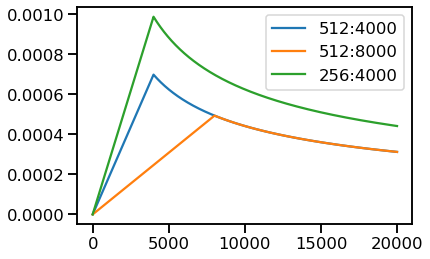

In [86]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [19]:
class SimpleLossCompute:
    def __init__(self,criterion, opt = None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y):
        loss = self.criterion(x,y)
        
        
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item()* x[1].sum().item()


### Testing 

In [21]:
# 
model = model.to(device)
criterion = LabelSmoothing(len(en_itos), 1, 0.1).to(device)

model_opt = NoamOpt(model.src_emb[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(3):
    model.train()
    run_epoch(train_dl,model,SimpleLossCompute(criterion,opt= model_opt))
    
    model.eval()
    with torch.no_grad():
        print(run_epoch(valid_dl,model,SimpleLossCompute(criterion,opt= None)))
    

/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch Step: 1 Loss: 9.290861129760742 Tokens per Sec: 272.8800667767954
Epoch Step: 51 Loss: 6.11293888092041 Tokens per Sec: 7899.658828210236
Epoch Step: 101 Loss: 4.49199914932251 Tokens per Sec: 7683.78343235481
Epoch Step: 151 Loss: 2.9240825176239014 Tokens per Sec: 7647.676308892074
Epoch Step: 201 Loss: 2.186105489730835 Tokens per Sec: 8190.247411356243
Epoch Step: 251 Loss: 1.2507878541946411 Tokens per Sec: 7611.785377471756
Epoch Step: 301 Loss: 1.020182490348816 Tokens per Sec: 7563.127326810596
Epoch Step: 351 Loss: 0.7417226433753967 Tokens per Sec: 7517.408570611948
Epoch Step: 401 Loss: 0.4353657066822052 Tokens per Sec: 7979.3790269281435
Epoch Step: 451 Loss: 0.41121676564216614 Tokens per Sec: 8054.616440134829
Epoch Step: 501 Loss: 0.34375303983688354 Tokens per Sec: 8057.248733358604
Epoch Step: 551 Loss: 0.3475461006164551 Tokens per Sec: 8178.2270101791
Epoch Step: 601 Loss: 0.34575530886650085 Tokens per Sec: 7953.033643605958
Epoch Step: 651 Loss: 0.2677520811

In [20]:
# greedy decode 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1,1).fill_(start_symbol).type_as(src.data)
    set_trace()
    for i in range (max_len-1):
        out = model.decoder(model.tar_emb(Variable(ys)),memory, src_mask,Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:,-1]) # pull hidden state of last words
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data.squeeze(0)
        ys = torch.cat([ys,
                       torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()

text = "xxbos qu'est - ce que la stratégie sur les océans du canada ?"

src = Variable(torch.LongTensor(databunch.x.process_one(text)[1:]).unsqueeze(0))
src_mask = Variable(torch.ones(1, 1, 13))
print(greedy_decode(model.to('cpu'), src, src_mask, max_len=13, start_symbol=2))

> /home/skumar/DataScience/Projects_Section/Projects_Working/Attention_is_all_you_need/modules/model.py(168)attention()
-> if mask is not None: score = scores.masked_fill(mask == 1, -1e9)
(Pdb) c
> /home/skumar/DataScience/Projects_Section/Projects_Working/Attention_is_all_you_need/modules/model.py(168)attention()
-> if mask is not None: score = scores.masked_fill(mask == 1, -1e9)
(Pdb) c
> /home/skumar/DataScience/Projects_Section/Projects_Working/Attention_is_all_you_need/modules/model.py(168)attention()
-> if mask is not None: score = scores.masked_fill(mask == 1, -1e9)
(Pdb) c
> /home/skumar/DataScience/Projects_Section/Projects_Working/Attention_is_all_you_need/modules/model.py(168)attention()
-> if mask is not None: score = scores.masked_fill(mask == 1, -1e9)
(Pdb) c
> /home/skumar/DataScience/Projects_Section/Projects_Working/Attention_is_all_you_need/modules/model.py(168)attention()
-> if mask is not None: score = scores.masked_fill(mask == 1, -1e9)
(Pdb) c
> /home/skumar/DataS

BdbQuit: 

In [45]:
text

<module 'fastai.text' from '/home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/fastai/text/__init__.py'>

In [46]:
databunch.x.process_one('bjme jli el ikg')

array([   2,    0,    0, 8920,    0])

In [83]:
print(greedy_decode(model.to('cpu'), src, src_mask, max_len=10, start_symbol=2))


> <ipython-input-76-bc4caa7467a1>(17)run_epoch()
     15         if i%50 == 1:
     16             elapsed = time.time() - start
---> 17             print(f"Epoch Step: {i} Loss: {loss / batch.ntokens} Tokens per Sec: {tokens / elapsed}")
     18             start = time.time()
     19             tokens = 0

ipdb> exit


In [43]:
databunch.valid_ds.x.reconstruct("xxbos qu'est - ce que la stratégie sur les océans du canada ?")

AttributeError: 'bool' object has no attribute 'nonzero'

array([   2,    2,   48,   11,   28,   20,   13,  359,   35,   12, 3002,   25,   47,    9])